In my implementation, I have focused on implementing Integrated Gradients (Sundararajan et. al.) which was the precursor to DeepLIFT. DeepLIFT with ReScale rule is actually an efficient equivalent of integrated gradients. I have not implemented DeepLIFT from scratch due to the complications involved in dealing with different layers.

I have used DeepLIFT from the Captum package to compare with Integrated Gradients.

Model chosen is Googlenet.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import torch, torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
!pip install captum
from captum.attr import DeepLift, IntegratedGradients
!pip install torchsummary
from torchvision import models
from torchsummary import summary
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
img_cat = Image.open("/content/drive/MyDrive/cat.jpg").convert('RGB')
img_panda = Image.open("/content/drive/MyDrive/panda.jpeg").convert('RGB')
preprocess_to_attribute = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
preprocess_to_size = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    return image
img_cat = preprocess_to_size(img_cat)
img_panda = preprocess_to_size(img_panda)

cuda


In [ ]:
%%capture
googlenet=models.googlenet(pretrained=True)
alexnet = models.alexnet(pretrained=True)
googlenet.eval()
alexnet.eval()
with open('/content/drive/MyDrive/ImageNetLabels.txt') as f:
    labels = [line.strip() for line in f.readlines()]
labels = np.array(labels)


In [ ]:
def get_attrs(model=googlenet, image=img_cat, baseline=None, method="DeepLIFT", idx=388):
    _, idx = torch.topk(model(image.unsqueeze(0))[0], 1); idx=idx[0].item(); attributer = None
    if method=="DeepLIFT":
        attributer=DeepLift(model)
    elif method=="IntegratedGradients":
        attributer=IntegratedGradients(model)
    attribution = attributer.attribute(image.unsqueeze(0), target=idx) if baseline==None else attributer.attribute(image.unsqueeze(0), target=idx, baselines=baseline.unsqueeze(0))
    return attribution[0]


In [ ]:
def plot_attributions(img=None, base=None, attrs=None, cmap=plt.cm.viridis):
    image=img.detach()
    baseline=base.detach()
    attributions=attrs.detach()
    if baseline==None:
        baseline=torch.zeros_like(image)
    image=image.cpu()
    baseline=baseline.cpu()
    attributions=attributions.cpu()
    if attributions.ndim==3:
        attributions = torch.sum(torch.abs(attributions), axis=0) # need to ad absolute attributions up so as to 
    image=image.permute(1, 2, 0) 
    baseline=baseline.permute(1, 2, 0)
    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))
    # fig.clear()
    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attributions, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attributions, cmap=cmap)
    axs[1, 1].imshow(image, alpha=0.4)
    axs[1, 1].axis('off')

    plt.tight_layout()
    # plt.show()
    return fig

In [ ]:
def interpolation_points(base, final, n):
    base_interp = base.unsqueeze(0)
    final_interp = final.unsqueeze(0)
    steps = torch.linspace(0, 1, steps=n, device=base.device)
    for _ in range(base.ndim):
        steps = steps.unsqueeze(-1)
    return base_interp+(final_interp-base_interp)*steps

def grad(model, point, idx):
    def function(x):
        return model(x)[0,idx]
    ret = torch.autograd.functional.jacobian(function, point.unsqueeze(0))
    ret = ret[0][0]
    return ret

def integrated_gradients(model, image, baseline, n=20):
    img_batch = image.unsqueeze(0)
    out = model(img_batch)[0]
    _, idx = torch.topk(out, 1)
    interps = interpolation_points(image, baseline, n)
    gradients = torch.zeros_like(image)
    for point in interps:
        gradients += grad(model, point, idx)
    int_grad = gradients/n
    return int_grad


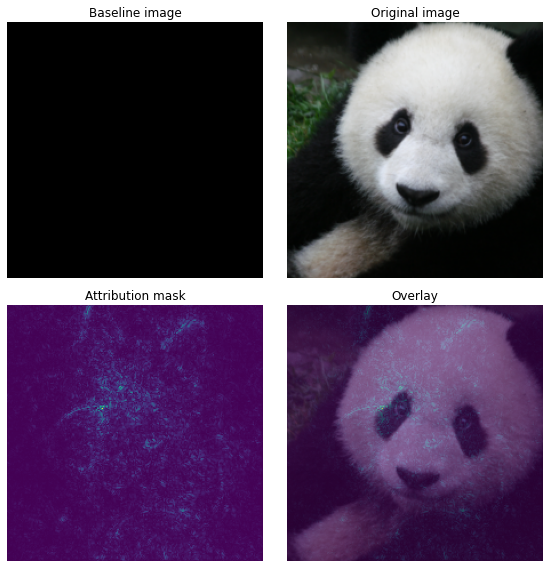

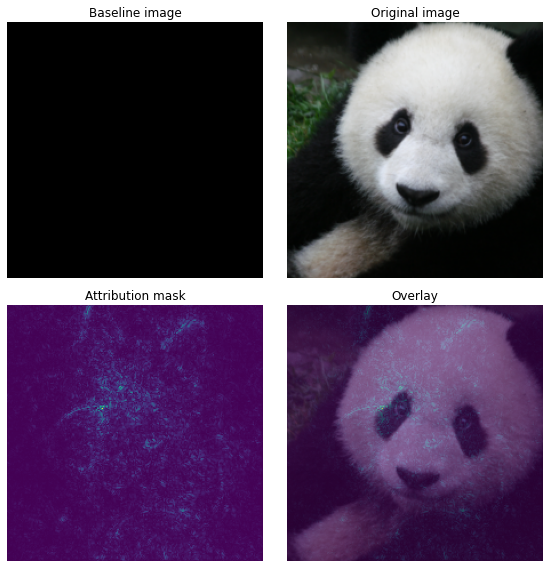

In [ ]:
panda_base = torch.zeros_like(img_panda)
IGattr = integrated_gradients(model=googlenet, image=img_cat, baseline=panda_base, n=20)
plot_attributions(img_panda, panda_base, IGattr)

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


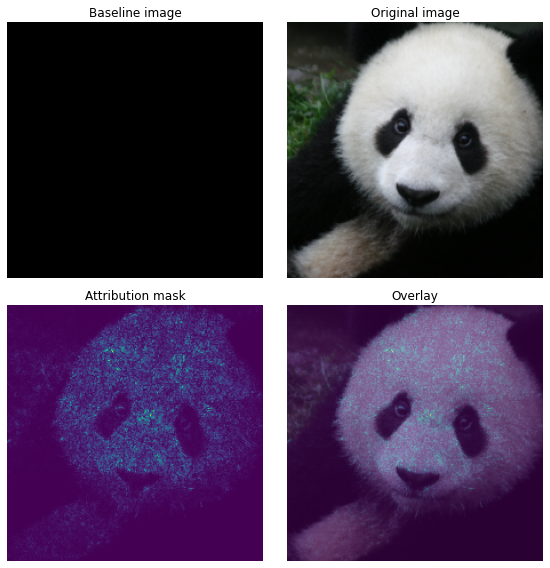

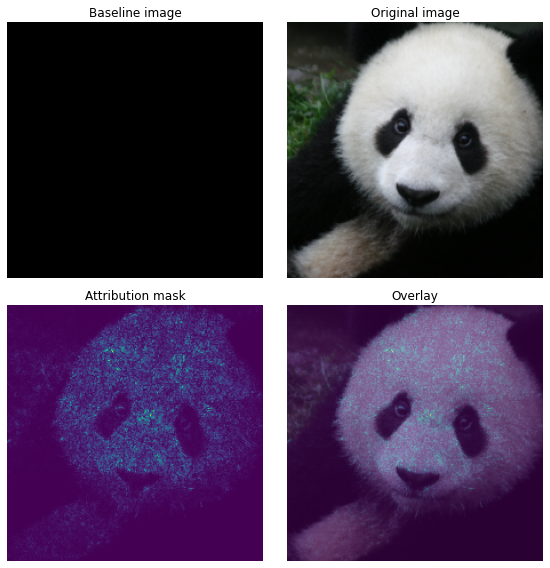

In [ ]:
panda_base = torch.zeros_like(img_panda)
DeepAttr = get_attrs(model=googlenet, image=img_panda, baseline=None, method="DeepLIFT")
plot_attributions(img_panda, panda_base, DeepAttr)

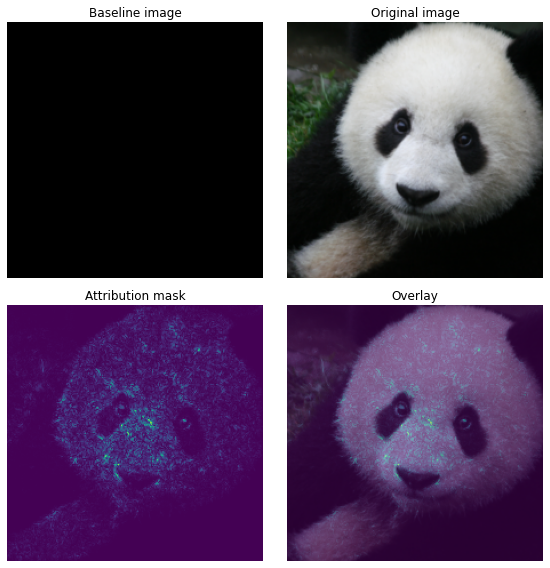

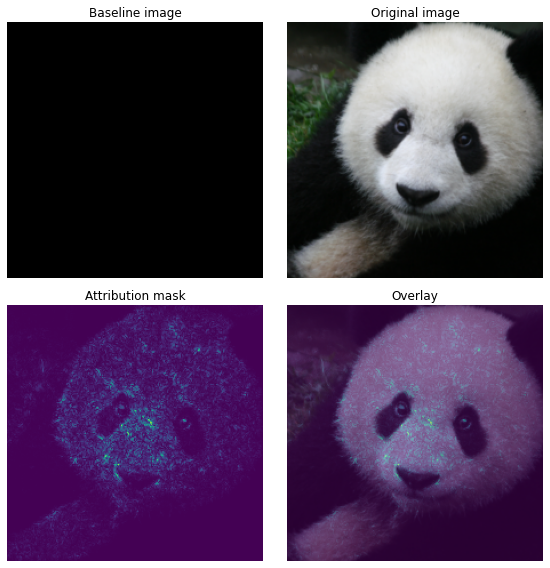

In [ ]:
panda_base = torch.zeros_like(img_panda)
IGttr = get_attrs(model=googlenet, image=img_panda, baseline=None, method="IntegratedGradients")
plot_attributions(img_panda, panda_base, IGAttr)